In [1]:
import numpy as np
import pandas as pd
import json
import math

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# DATA LOADING

In [7]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS:
        if s in df_grouped.groups:
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files, hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(bid_dist-ask_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        if not sym in hist_trades:
            continue
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [231]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50, 100, 200, 500, 1000, 2000]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
#     for t in MOVING_WINDOW_TIMES:
#         md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
#         md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
#         md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
#     for t in HIST_PX_TIMES:
#         # Price move since the past
#         md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
#         md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
#         md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
#         md[f'px_move_{t}'].fillna(0, inplace=True)
#         md[f'bid_move_{t}'].fillna(0, inplace=True)
#         md[f'ask_move_{t}'].fillna(0, inplace=True)
        
#         md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
#         # log return
#         md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
#         md[f'log_return_{t}'].fillna(1, inplace=True)
#     md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    get_quote_stats(md)
    md = md.copy()
    get_quote_tick_change(md)
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3']].sum(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3']].sum(axis=1)
    # md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3']].max(axis=1)
    # md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3']].max(axis=1)
    
#     md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
#     md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
    
    return md

def get_quote_tick_change(md):
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return

def get_quote_stats(md):
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    
    return

def basic_quote_analysis(md):
    md = md.copy()
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    get_quote_stats(md)
    get_quote_tick_change(md)
    
    return md.copy()

def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            'fpx_move_10': ['mean','std'], 'fpx_move_1': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market


def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty', 'fill_pct']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders.loc[orders.fill_pct < 1][orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

In [107]:
def trade_analysis(orders):
    # For historical trades
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    
    for t in FUTURE_TIMES:
        orders[f'tox_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['quantity']*orders[f'tox_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
    
    return

## Load

In [359]:
SYMBOLS = ['PEARLS','BANANAS']
SYMBOLS = ['COCONUTS','PINA_COLADAS']
SYMBOLS = ['DIVING_GEAR','BERRIES']
SYMBOLS = ['PICNIC_BASKET','DIP','BAGUETTE','UKULELE']

SYMBOLS = ['BANANAS', 'COCONUTS','PINA_COLADAS', 'DIVING_GEAR','BERRIES', 'PICNIC_BASKET','DIP','BAGUETTE','UKULELE']

In [232]:
quote_files, trade_files = [], []

data_dir = 'hist_data/island-data-bottle-round-1/'
hist_days = [-2]
quote_files += [f'{data_dir}prices_round_1_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_1_day_{i}_wn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1]
quote_files += [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_2_day_{i}_wn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [0]
quote_files += [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_3_day_{i}_wn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-4/'
hist_days = [1, 2, 3]
quote_files += [f'{data_dir}prices_round_4_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_4_day_{i}_wn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, [-2, -1, 0, 1, 2, 3])

In [79]:
trader_full_list = ['Peter','Mitch','Gary','Penelope','Omar',
               'Camilla','Caesar','Giulia','Mabel','Charlie',
               'Pablo','Olivia','Orson','Casey','George','Mya',
               'Max','Paris','Gina','Olga']

In [83]:
traders_set = set()
for sym in SYMBOLS:
    trades = hist_trades[sym]
    traders_set = traders_set.union(set(trades.seller.unique()))
    traders_set = traders_set.union(set(trades.buyer.unique()))
# N/A traders / traders that sit deeper in the book
print(set(trader_list).difference(traders_set))
print(traders_set)

{'Mitch', 'Mya', 'Giulia', 'Orson', 'George', 'Omar', 'Mabel', 'Casey', 'Max'}
{'Gary', 'Gina', 'Charlie', 'Camilla', 'Caesar', 'Olga', 'Paris', 'Peter', 'Pablo', 'Olivia', 'Penelope'}


In [217]:
import collections

def is_passive_party(x):
    return (x['price'] == x['bid'] and x['trader_side'] == 1) or (x['price'] == x['ask'] and x['trader_side'] == -1)

def is_active_party(x):
    return (x['price'] == x['bid'] and x['trader_side'] == -1) or (x['price'] == x['ask'] and x['trader_side'] == 1)

In [233]:
# Trader summary
summary = []
trades_by_trader = collections.defaultdict(list)
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    quote = basic_quote_analysis(quote)
    trades = hist_trades[sym].drop(columns=['bid_3','bid_sz_3','ask_3', 'ask_sz_3','bid_4', 'bid_sz_4', 'ask_4', 'ask_sz_4',
           'bid_5', 'bid_sz_5', 'ask_5', 'ask_sz_5'])
    close_px = quote.groupby('day')['mid_price'].last().rename('close_px')
    trades = trades.join(close_px, on='day')
    trades = trades.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    trades.drop(trades.filter(regex='_q$').columns, axis=1, inplace=True)
    trade_analysis(trades)

    sym_trades_by_trader = {}
    for t in traders_set:
        buy_trades = trades.loc[trades.buyer == t].copy()
        buy_trades['trader_side'] = 1
        sell_trades = trades.loc[trades.seller == t].copy()
        sell_trades['trader_side'] = -1
        sym_trades_by_trader[t] = pd.concat([buy_trades, sell_trades], ignore_index=True)
        sym_trades_by_trader[t].sort_values(['day','timestamp'], inplace=True)
        sym_trades_by_trader[t].reset_index(drop=True,inplace=True)
    
    for t in sym_trades_by_trader:
        if sym_trades_by_trader[t].empty:
            continue
        trades_by_trader[t].append(sym_trades_by_trader[t])
        trades = sym_trades_by_trader[t]
        trades['trade_pnl'] = trades['trader_side']*(trades['close_px']-trades['price'])
        trades['passive'] = trades.apply(is_passive_party, axis=1)
        trades['active'] = trades.apply(is_active_party, axis=1)
        
        
        # number of trades, pnl, avg size, avg spread, buy and sell
        trader_summary = {}
        trader_summary['trader'] = t
        trader_summary['sym'] = sym
        trader_summary['pnl'] = trades['trade_pnl'].sum()
        trader_summary['count'] = len(trades)
        trader_summary['buy_trades'] = len(trades.loc[trades.trader_side == 1])
        trader_summary['sell_trades'] = len(trades.loc[trades.trader_side == -1])
        trader_summary['volume'] = trades['quantity'].sum()
        trader_summary['active_vol'] = (trades['quantity']*trades['active']).sum()
        trader_summary['passive_vol'] = (trades['quantity']*trades['passive']).sum()
        trader_summary['buy_volume'] = trades.loc[trades.trader_side == 1]['quantity'].sum()    
        trader_summary['sell_volume'] = trades.loc[trades.trader_side == -1]['quantity'].sum()    
        trader_summary['avg_buy_size'] = trades.loc[trades.trader_side == 1]['quantity'].mean()
        trader_summary['avg_sell_size'] = trades.loc[trades.trader_side == -1]['quantity'].mean()
        trader_summary['avg_spread'] = trades['spread'].mean()
        trader_summary['buy_pnl'] = trades.loc[trades.trader_side == 1]['trade_pnl'].sum()
        trader_summary['sell_pnl'] = trades.loc[trades.trader_side == -1]['trade_pnl'].sum()
        trader_summary['pnl/share'] = trader_summary['pnl']/trader_summary['volume']
        
        summary.append(trader_summary)

for t in trades_by_trader:
    trades_by_trader[t] = pd.concat(trades_by_trader[t])
    
summary = pd.DataFrame.from_records(summary, index='trader')
summary

,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Gary,PEARLS,-4012.0,1174,592,582,5907,5907,0,3047,2860,5.146959,4.914089,6.793867,-2520.0,-1492.0,-0.679194
Gina,PEARLS,-679.0,541,262,279,2252,175,1790,1108,1144,4.229008,4.100358,2.863216,-546.0,-133.0,-0.301510
Charlie,PEARLS,20710.0,6965,3512,3453,17604,7669,9819,8809,8795,2.508257,2.547061,4.461019,7576.0,13134.0,1.176437
Camilla,PEARLS,5615.0,2881,1495,1386,6211,1162,4628,3218,2993,2.152508,2.159452,5.927803,1725.0,3890.0,0.904041
Caesar,PEARLS,13460.0,3621,1808,1813,5133,173,4605,2559,2574,1.415376,1.419746,6.541011,5241.0,8219.0,2.622248
Paris,PEARLS,-22326.0,8805,4426,4379,10171,6577,3111,5133,5038,1.159738,1.150491,5.074049,-14895.0,-7431.0,-2.195064
Pablo,PEARLS,-5270.0,2668,1303,1365,6889,1171,5204,3393,3496,2.603991,2.561172,3.302849,-3664.0,-1606.0,-0.764988
Penelope,PEARLS,-7498.0,2165,1012,1153,6423,6357,34,3028,3395,2.992095,2.944493,6.799076,-4384.0,-3114.0,-1.167367
Gary,BANANAS,-2168.5,1163,558,605,13195,13195,0,6484,6711,11.620072,11.092562,5.230439,-12694.0,10525.5,-0.164343


## By Trader

In [221]:
for t in traders_set:
    display(summary.loc[t])

,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Gary,PEARLS,-4012.0,1174,592,582,5907,5907,0,3047,2860,5.146959,4.914089,6.793867,-2520.0,-1492.0,-0.679194
Gary,BANANAS,-2168.5,1163,558,605,13195,13195,0,6484,6711,11.620072,11.092562,5.230439,-12694.0,10525.5,-0.164343
Gary,BERRIES,-2020.0,412,199,213,5865,5865,0,2814,3051,14.140704,14.323944,6.368932,-8527.5,6507.5,-0.344416


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Gina,PEARLS,-679.0,541,262,279,2252,175,1790,1108,1144,4.229008,4.100358,2.863216,-546.0,-133.0,-0.301510
Gina,BANANAS,-164.0,1034,490,544,6434,275,5806,3204,3230,6.538776,5.937500,1.595745,-10335.0,10171.0,-0.025490
Gina,BERRIES,-101.5,33,14,19,215,0,215,103,112,7.357143,5.894737,3.000000,-377.0,275.5,-0.472093


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Charlie,PEARLS,20710.0,6965,3512,3453,17604,7669,9819,8809,8795,2.508257,2.547061,4.461019,7576.0,13134.0,1.176437
Charlie,BANANAS,7392.0,11158,6084,5074,37858,11088,26375,19930,17928,3.275805,3.533307,3.996774,-110208.0,117600.0,0.195256
Charlie,COCONUTS,4636.5,816,537,279,10019,0,10012,7900,2119,14.711359,7.594982,2.650735,5811.5,-1175.0,0.462771
Charlie,PINA_COLADAS,3006.0,594,397,197,3233,0,3233,2535,698,6.385390,3.543147,2.909091,7321.5,-4315.5,0.929787
Charlie,DIVING_GEAR,-14161.0,1329,800,529,2601,74,2525,1576,1025,1.970000,1.937618,2.858540,25623.5,-39784.5,-5.444444
Charlie,BERRIES,199.0,58,22,36,626,0,524,258,368,11.727273,10.222222,6.810345,-667.0,866.0,0.317891


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Camilla,PEARLS,5615.0,2881,1495,1386,6211,1162,4628,3218,2993,2.152508,2.159452,5.927803,1725.0,3890.0,0.904041
Camilla,BANANAS,7166.5,2979,1437,1542,5888,820,4125,2866,3022,1.994433,1.959792,4.845921,-26536.5,33703.0,1.217137
Camilla,DIVING_GEAR,-18071.0,2359,1066,1293,4629,1609,3020,2074,2555,1.945591,1.976025,2.092836,61206.0,-79277.0,-3.903867
Camilla,BERRIES,10269.5,2087,1006,1081,18767,0,18748,9176,9591,9.121272,8.872340,6.636320,-31422.0,41691.5,0.547211
Camilla,PICNIC_BASKET,12297.5,720,427,293,3737,986,2751,2110,1627,4.941452,5.552901,8.551389,15758.0,-3460.5,3.290741
Camilla,DIP,17652.0,1017,26,991,7342,7004,338,152,7190,5.846154,7.255298,1.501475,-778.0,18430.0,2.404250
Camilla,BAGUETTE,-54464.5,546,6,540,3721,3649,72,33,3688,5.500000,6.829630,1.430403,690.5,-55155.0,-14.637060
Camilla,UKULELE,45249.0,296,6,290,1976,1950,26,14,1962,2.333333,6.765517,1.290541,-696.0,45945.0,22.899291


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Caesar,PEARLS,13460.0,3621,1808,1813,5133,173,4605,2559,2574,1.415376,1.419746,6.541011,5241.0,8219.0,2.622248
Caesar,BANANAS,-3668.0,2221,1317,904,3358,266,2481,1672,1686,1.269552,1.865044,4.514633,-23794.5,20126.5,-1.092317
Caesar,COCONUTS,73.0,1598,791,807,62922,30248,31329,31145,31777,39.374210,39.376704,1.453692,7880.0,-7807.0,0.001160
Caesar,PINA_COLADAS,951.5,1121,610,511,18529,8055,9632,9708,8821,15.914754,17.262231,1.615522,5711.0,-4759.5,0.051352
Caesar,PICNIC_BASKET,-11597.0,1053,563,490,1734,351,945,934,800,1.658970,1.632653,8.165242,5042.0,-16639.0,-6.688005
Caesar,DIP,-15946.5,3377,2186,1191,23862,0,23862,15645,8217,7.156908,6.899244,1.647024,-41729.5,25783.0,-0.668280
Caesar,BAGUETTE,67559.5,2860,1720,1140,16392,0,16392,10205,6187,5.933140,5.427193,1.570280,179345.0,-111785.5,4.121492
Caesar,UKULELE,-37455.0,3016,1609,1407,10170,0,10170,5966,4204,3.707893,2.987918,1.385942,-275878.5,238423.5,-3.682891


sym               BANANAS
pnl                 -35.0
count                   1
buy_trades              1
sell_trades             0
volume                  9
active_vol              9
passive_vol             0
buy_volume              9
sell_volume             0
avg_buy_size          9.0
avg_sell_size         NaN
avg_spread            1.0
buy_pnl             -35.0
sell_pnl              0.0
pnl/share       -3.888889
Name: Olga, dtype: object

,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Paris,PEARLS,-22326.0,8805,4426,4379,10171,6577,3111,5133,5038,1.159738,1.150491,5.074049,-14895.0,-7431.0,-2.195064
Paris,BANANAS,-8077.5,11644,5384,6260,13319,8957,2895,6263,7056,1.163262,1.127157,4.254981,-121834.5,113757.0,-0.606464
Paris,DIVING_GEAR,32232.0,1956,956,1000,3864,3862,0,1897,1967,1.984310,1.967000,2.455010,64529.0,-32297.0,8.341615
Paris,BERRIES,-5720.5,1237,655,582,6753,6663,40,3528,3225,5.386260,5.541237,6.449475,-24262.5,18542.0,-0.847105
Paris,DIP,-1705.5,2478,1224,1254,17196,17196,0,8403,8793,6.865196,7.011962,1.675948,-26392.5,24687.0,-0.099180
Paris,BAGUETTE,-13095.0,2340,1147,1193,12815,12815,0,6226,6589,5.428073,5.523051,1.596581,112679.5,-125774.5,-1.021849
Paris,UKULELE,-9045.0,2734,1408,1326,8228,8228,0,4207,4021,2.987926,3.032428,1.393197,-239085.0,230040.0,-1.099295


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Peter,COCONUTS,-1199.5,708,358,350,5368,5361,0,2713,2655,7.578212,7.585714,2.495763,1547.0,-2746.5,-0.223454
Peter,PINA_COLADAS,-2081.5,645,297,348,2206,2202,0,1032,1174,3.474747,3.373563,2.613953,5841.5,-7923.0,-0.943563
Peter,BERRIES,534.5,133,59,74,391,134,257,171,220,2.898305,2.972973,2.992481,-1892.5,2427.0,1.367008


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Pablo,PEARLS,-5270.0,2668,1303,1365,6889,1171,5204,3393,3496,2.603991,2.561172,3.302849,-3664.0,-1606.0,-0.764988
Pablo,BANANAS,2158.5,1913,821,1092,4765,466,3811,1995,2770,2.429963,2.536630,2.117616,-18321.0,20479.5,0.452991
Pablo,COCONUTS,-3510.0,408,79,329,7955,6830,1098,1374,6581,17.392405,20.003040,2.198529,256.0,-3766.0,-0.441232
Pablo,PINA_COLADAS,-1876.0,386,69,317,3888,3248,640,653,3235,9.463768,10.205047,2.225389,1764.5,-3640.5,-0.482510
Pablo,BERRIES,-300.0,70,42,28,390,82,308,239,151,5.690476,5.392857,3.171429,-1220.0,920.0,-0.769231
Pablo,PICNIC_BASKET,7622.5,976,388,588,2774,1008,1329,1069,1705,2.755155,2.899660,6.050205,13215.5,-5593.0,2.747837


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Olivia,BANANAS,512.0,17,8,9,204,115,0,102,102,12.750000,11.333333,5.117647,50.5,461.5,2.509804
Olivia,BERRIES,506.0,12,6,6,136,112,0,68,68,11.333333,11.333333,5.916667,81.0,425.0,3.720588
Olivia,UKULELE,1251.0,6,3,3,18,18,0,9,9,3.000000,3.000000,1.500000,139.5,1111.5,69.500000


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Penelope,PEARLS,-7498.0,2165,1012,1153,6423,6357,34,3028,3395,2.992095,2.944493,6.799076,-4384.0,-3114.0,-1.167367
Penelope,BANANAS,-3116.0,1938,934,1004,10390,10336,34,5185,5205,5.551392,5.184263,5.194014,-21558.5,18442.5,-0.299904
Penelope,BERRIES,-3367.0,638,337,301,7357,7273,37,3893,3464,11.551929,11.508306,6.468652,-12449.5,9082.5,-0.457659
Penelope,PICNIC_BASKET,-8323.0,767,380,387,2681,2680,0,1350,1331,3.552632,3.439276,11.311604,5103.5,-13426.5,-3.104439


## By Symbol

In [360]:
for sym in SYMBOLS:
    display(summary.loc[summary.sym == sym])

,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Gary,BANANAS,-2168.5,1163,558,605,13195,13195,0,6484,6711,11.620072,11.092562,5.230439,-12694.0,10525.5,-0.164343
Gina,BANANAS,-164.0,1034,490,544,6434,275,5806,3204,3230,6.538776,5.937500,1.595745,-10335.0,10171.0,-0.025490
Charlie,BANANAS,7392.0,11158,6084,5074,37858,11088,26375,19930,17928,3.275805,3.533307,3.996774,-110208.0,117600.0,0.195256
Camilla,BANANAS,7166.5,2979,1437,1542,5888,820,4125,2866,3022,1.994433,1.959792,4.845921,-26536.5,33703.0,1.217137
Caesar,BANANAS,-3668.0,2221,1317,904,3358,266,2481,1672,1686,1.269552,1.865044,4.514633,-23794.5,20126.5,-1.092317
Olga,BANANAS,-35.0,1,1,0,9,9,0,9,0,9.000000,NaN,1.000000,-35.0,0.0,-3.888889
Paris,BANANAS,-8077.5,11644,5384,6260,13319,8957,2895,6263,7056,1.163262,1.127157,4.254981,-121834.5,113757.0,-0.606464
Pablo,BANANAS,2158.5,1913,821,1092,4765,466,3811,1995,2770,2.429963,2.536630,2.117616,-18321.0,20479.5,0.452991
Olivia,BANANAS,512.0,17,8,9,204,115,0,102,102,12.750000,11.333333,5.117647,50.5,461.5,2.509804


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Charlie,COCONUTS,4636.5,816,537,279,10019,0,10012,7900,2119,14.711359,7.594982,2.650735,5811.5,-1175.0,0.462771
Caesar,COCONUTS,73.0,1598,791,807,62922,30248,31329,31145,31777,39.374210,39.376704,1.453692,7880.0,-7807.0,0.001160
Peter,COCONUTS,-1199.5,708,358,350,5368,5361,0,2713,2655,7.578212,7.585714,2.495763,1547.0,-2746.5,-0.223454
Pablo,COCONUTS,-3510.0,408,79,329,7955,6830,1098,1374,6581,17.392405,20.003040,2.198529,256.0,-3766.0,-0.441232


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Charlie,PINA_COLADAS,3006.0,594,397,197,3233,0,3233,2535,698,6.385390,3.543147,2.909091,7321.5,-4315.5,0.929787
Caesar,PINA_COLADAS,951.5,1121,610,511,18529,8055,9632,9708,8821,15.914754,17.262231,1.615522,5711.0,-4759.5,0.051352
Peter,PINA_COLADAS,-2081.5,645,297,348,2206,2202,0,1032,1174,3.474747,3.373563,2.613953,5841.5,-7923.0,-0.943563
Pablo,PINA_COLADAS,-1876.0,386,69,317,3888,3248,640,653,3235,9.463768,10.205047,2.225389,1764.5,-3640.5,-0.482510


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Charlie,DIVING_GEAR,-14161.0,1329,800,529,2601,74,2525,1576,1025,1.970000,1.937618,2.858540,25623.5,-39784.5,-5.444444
Camilla,DIVING_GEAR,-18071.0,2359,1066,1293,4629,1609,3020,2074,2555,1.945591,1.976025,2.092836,61206.0,-79277.0,-3.903867
Paris,DIVING_GEAR,32232.0,1956,956,1000,3864,3862,0,1897,1967,1.984310,1.967000,2.455010,64529.0,-32297.0,8.341615


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Gary,BERRIES,-2020.0,412,199,213,5865,5865,0,2814,3051,14.140704,14.323944,6.368932,-8527.5,6507.5,-0.344416
Gina,BERRIES,-101.5,33,14,19,215,0,215,103,112,7.357143,5.894737,3.000000,-377.0,275.5,-0.472093
Charlie,BERRIES,199.0,58,22,36,626,0,524,258,368,11.727273,10.222222,6.810345,-667.0,866.0,0.317891
Camilla,BERRIES,10269.5,2087,1006,1081,18767,0,18748,9176,9591,9.121272,8.872340,6.636320,-31422.0,41691.5,0.547211
Paris,BERRIES,-5720.5,1237,655,582,6753,6663,40,3528,3225,5.386260,5.541237,6.449475,-24262.5,18542.0,-0.847105
Peter,BERRIES,534.5,133,59,74,391,134,257,171,220,2.898305,2.972973,2.992481,-1892.5,2427.0,1.367008
Pablo,BERRIES,-300.0,70,42,28,390,82,308,239,151,5.690476,5.392857,3.171429,-1220.0,920.0,-0.769231
Olivia,BERRIES,506.0,12,6,6,136,112,0,68,68,11.333333,11.333333,5.916667,81.0,425.0,3.720588
Penelope,BERRIES,-3367.0,638,337,301,7357,7273,37,3893,3464,11.551929,11.508306,6.468652,-12449.5,9082.5,-0.457659


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Camilla,PICNIC_BASKET,12297.5,720,427,293,3737,986,2751,2110,1627,4.941452,5.552901,8.551389,15758.0,-3460.5,3.290741
Caesar,PICNIC_BASKET,-11597.0,1053,563,490,1734,351,945,934,800,1.658970,1.632653,8.165242,5042.0,-16639.0,-6.688005
Pablo,PICNIC_BASKET,7622.5,976,388,588,2774,1008,1329,1069,1705,2.755155,2.899660,6.050205,13215.5,-5593.0,2.747837
Penelope,PICNIC_BASKET,-8323.0,767,380,387,2681,2680,0,1350,1331,3.552632,3.439276,11.311604,5103.5,-13426.5,-3.104439


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Camilla,DIP,17652.0,1017,26,991,7342,7004,338,152,7190,5.846154,7.255298,1.501475,-778.0,18430.0,2.40425
Caesar,DIP,-15946.5,3377,2186,1191,23862,0,23862,15645,8217,7.156908,6.899244,1.647024,-41729.5,25783.0,-0.66828
Paris,DIP,-1705.5,2478,1224,1254,17196,17196,0,8403,8793,6.865196,7.011962,1.675948,-26392.5,24687.0,-0.09918


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Camilla,BAGUETTE,-54464.5,546,6,540,3721,3649,72,33,3688,5.500000,6.829630,1.430403,690.5,-55155.0,-14.637060
Caesar,BAGUETTE,67559.5,2860,1720,1140,16392,0,16392,10205,6187,5.933140,5.427193,1.570280,179345.0,-111785.5,4.121492
Paris,BAGUETTE,-13095.0,2340,1147,1193,12815,12815,0,6226,6589,5.428073,5.523051,1.596581,112679.5,-125774.5,-1.021849


,sym,pnl,count,buy_trades,sell_trades,volume,active_vol,passive_vol,buy_volume,sell_volume,avg_buy_size,avg_sell_size,avg_spread,buy_pnl,sell_pnl,pnl/share
trader,,,,,,,,,,,,,,,,
Camilla,UKULELE,45249.0,296,6,290,1976,1950,26,14,1962,2.333333,6.765517,1.290541,-696.0,45945.0,22.899291
Caesar,UKULELE,-37455.0,3016,1609,1407,10170,0,10170,5966,4204,3.707893,2.987918,1.385942,-275878.5,238423.5,-3.682891
Paris,UKULELE,-9045.0,2734,1408,1326,8228,8228,0,4207,4021,2.987926,3.032428,1.393197,-239085.0,230040.0,-1.099295
Olivia,UKULELE,1251.0,6,3,3,18,18,0,9,9,3.000000,3.000000,1.500000,139.5,1111.5,69.500000


In [234]:
base_cols = ['day','symbol','timestamp','price','quantity','bid','ask','bid_sz','ask_sz',
             'buyer','seller', 'tox_5', 'tox_25','tox_50','tox_100','tox_1000','trade_pnl']

# Olivia

In [134]:
trades_by_trader['Olivia'][['day','symbol','timestamp','price','quantity','bid','ask','buyer','seller', 'fpx_5', 'fpx_50','trade_pnl']]

,day,symbol,timestamp,price,quantity,bid,ask,buyer,seller,fpx_5,fpx_50,trade_pnl
8,-2,BANANAS,336600,5000.0,17,5001.0,5007.0,Charlie,Olivia,-0.5,-5.5,51.5
0,-2,BANANAS,983800,4947.0,9,4940.0,4945.0,Olivia,Charlie,3.0,4.5,1.5
1,-2,BANANAS,983800,4945.0,8,4940.0,4945.0,Olivia,Camilla,3.0,4.5,3.5
9,-1,BANANAS,1279600,4953.0,17,4953.0,4960.0,Charlie,Olivia,-2.5,-2.0,58.0
2,-1,BANANAS,1985600,4892.0,17,4885.0,4892.0,Olivia,Charlie,0.5,6.5,3.0
10,0,BANANAS,2199500,4905.0,17,4905.0,4912.0,Charlie,Olivia,-2.0,-2.0,32.0
3,0,BANANAS,2999300,4875.0,17,4868.0,4875.0,Olivia,Charlie,1.0,0.0,-2.0
11,1,BANANAS,3090600,4887.0,2,4887.0,4893.0,Caesar,Olivia,-0.5,-7.5,63.5
12,1,BANANAS,3090600,4886.0,15,4887.0,4893.0,Charlie,Olivia,-0.5,-7.5,62.5
4,1,BANANAS,3868000,4805.0,17,4799.0,4805.0,Olivia,Charlie,1.0,4.0,18.5


# Paris

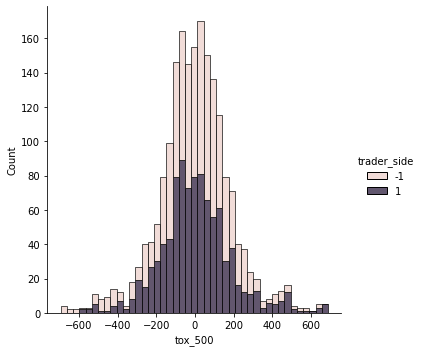

In [347]:
tra = trades_by_trader['Paris']
t = tra.loc[tra.symbol == 'DIVING_GEAR']
sns.displot(x='tox_500', data=t, hue='trader_side', multiple='stack')

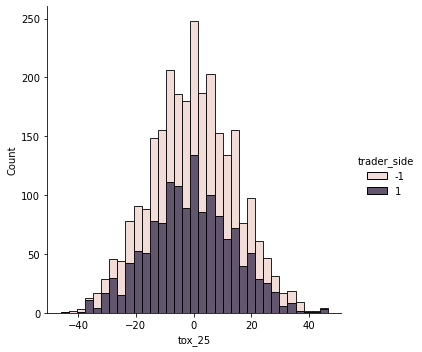

In [325]:
tra = trades_by_trader['Paris']
t = tra.loc[tra.symbol == 'UKULELE']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

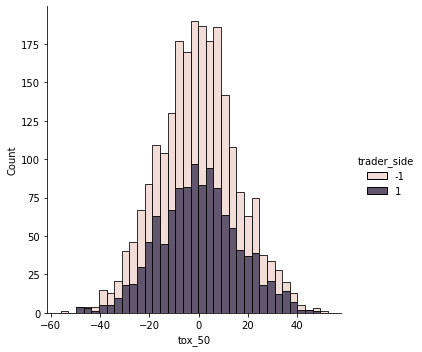

In [328]:
tra = trades_by_trader['Paris']
t = tra.loc[tra.symbol == 'BAGUETTE']
sns.displot(x='tox_50', data=t, hue='trader_side', multiple='stack')

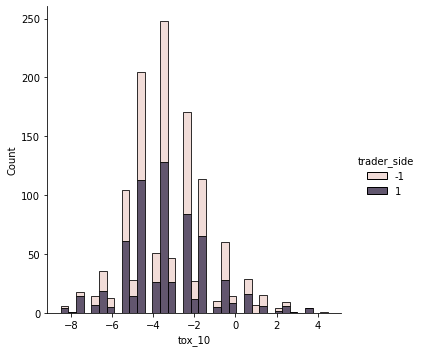

In [362]:
tra = trades_by_trader['Paris']
t = tra.loc[tra.symbol == 'BERRIES']
sns.displot(x='tox_10', data=t, hue='trader_side', multiple='stack')

# Camila

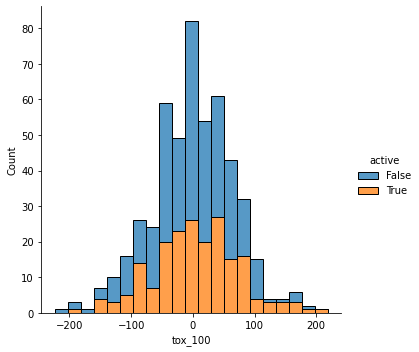

In [367]:
tra = trades_by_trader['Camilla']
t = tra.loc[tra.buyer == tra.seller]
t = t.loc[t.symbol == 'DIVING_GEAR']
t = t.loc[t.trader_side == 1]
sns.displot(x='tox_100', data=t, hue', multiple='stack')

# Charlie

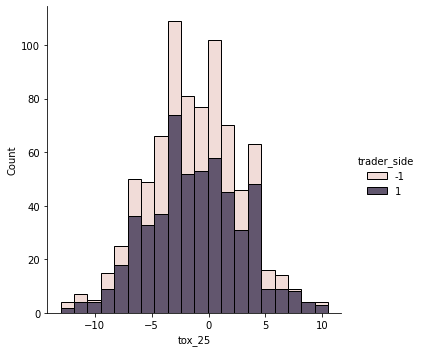

In [330]:
tra = trades_by_trader['Charlie']
t = tra.loc[tra.symbol == 'COCONUTS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

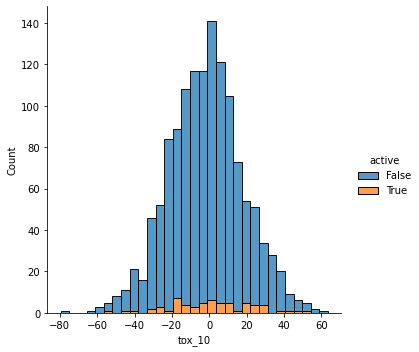

In [334]:
tra = trades_by_trader['Charlie']
t = tra.loc[tra.symbol == 'DIVING_GEAR']
sns.displot(x='tox_10', data=t, hue='active', multiple='stack')

# Penelope

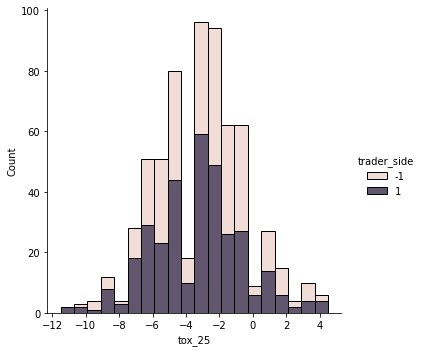

In [323]:
tra = trades_by_trader['Penelope']
t = tra.loc[tra.symbol == 'BERRIES']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

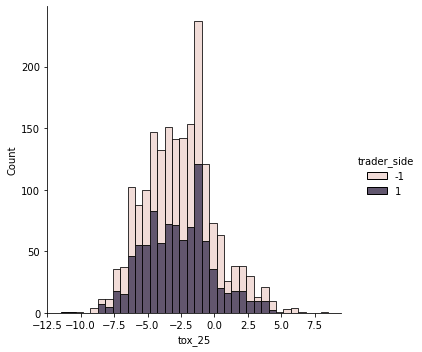

In [322]:
tra = trades_by_trader['Penelope']
t = tra.loc[tra.symbol == 'BANANAS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

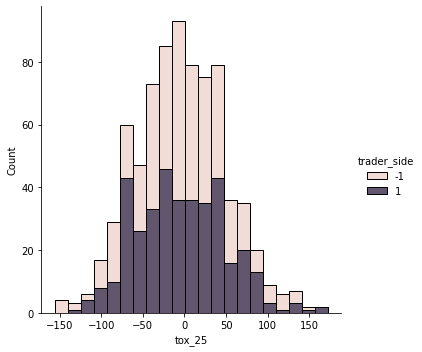

In [329]:
tra = trades_by_trader['Penelope']
t = tra.loc[tra.symbol == 'PICNIC_BASKET']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

# Gina

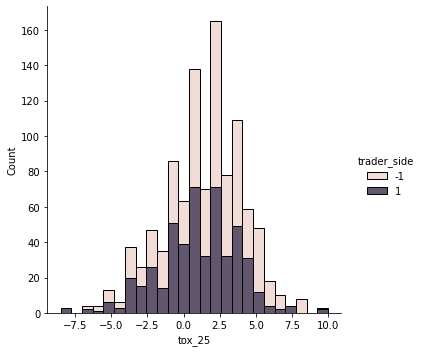

In [321]:
tra = trades_by_trader['Gina']
t = tra.loc[tra.symbol == 'BANANAS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

# Gary

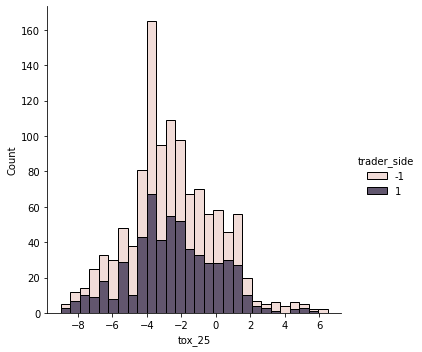

In [320]:
tra = trades_by_trader['Gary']
t = tra.loc[tra.symbol == 'BANANAS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

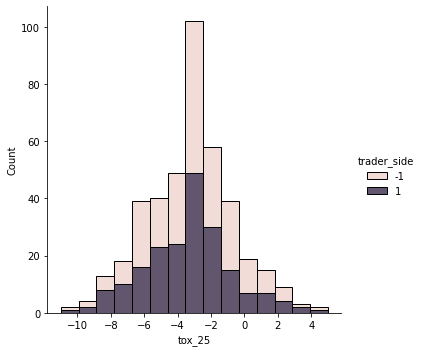

In [363]:
tra = trades_by_trader['Gary']
t = tra.loc[tra.symbol == 'BERRIES']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

# Peter

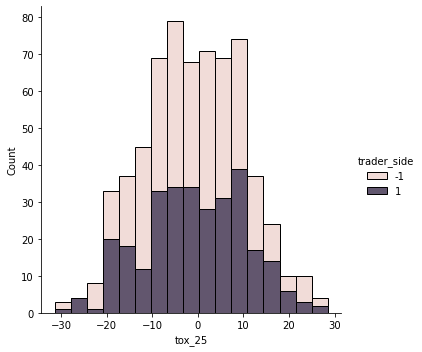

In [318]:
tra = trades_by_trader['Peter']
t = tra.loc[tra.symbol == 'PINA_COLADAS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

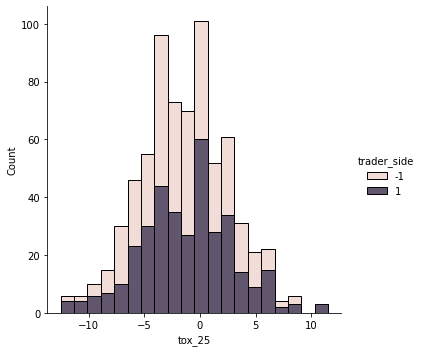

In [319]:
tra = trades_by_trader['Peter']
t = tra.loc[tra.symbol == 'COCONUTS']
sns.displot(x='tox_25', data=t, hue='trader_side', multiple='stack')

In [315]:
t['tox_100'].describe()

count    708.000000
mean      -1.324153
std        8.038306
min      -26.500000
25%       -7.000000
50%       -1.500000
75%        3.500000
max       27.000000
Name: tox_100, dtype: float64

# Pablo

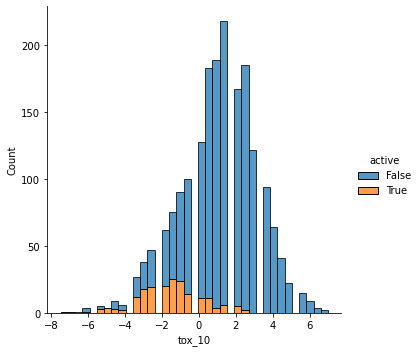

In [345]:
tra = trades_by_trader['Pablo']
t = tra.loc[tra.symbol == 'BANANAS']
sns.displot(x='tox_10', data=t, hue='active', multiple='stack')

In [341]:
t.head()

,timestamp,buyer,seller,symbol,currency,price,quantity,day,bid,bid_sz,...,tox_1000,pnl_1000,fill_revert_1000,tox_2000,pnl_2000,fill_revert_2000,trader_side,trade_pnl,passive,active
0,6900,Pablo,Charlie,BANANAS,SEASHELLS,4999.0,1,-2,4999.0,1.0,...,25.5,25.5,1.0,7.5,7.5,1.0,1,-50.5,True,False
1,6900,Pablo,Camilla,BANANAS,SEASHELLS,4999.0,1,-2,4999.0,1.0,...,25.5,25.5,1.0,7.5,7.5,1.0,1,-50.5,True,False
2,7400,Paris,Pablo,BANANAS,SEASHELLS,4996.0,1,-2,4995.0,28.0,...,22.5,22.5,1.0,6.5,6.5,1.0,-1,47.5,False,False
3,10500,Pablo,Charlie,BANANAS,SEASHELLS,4999.0,5,-2,4999.0,5.0,...,26.5,132.5,1.0,4.5,22.5,1.0,1,-50.5,True,False
4,17800,Pablo,Charlie,BANANAS,SEASHELLS,4995.0,5,-2,4995.0,5.0,...,20.5,102.5,1.0,6.0,30.0,1.0,1,-46.5,True,False
